Import Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib

Load Dataset

In [14]:
df = pd.read_csv("AAPL.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

print("Data Head:")
print(df.head())

Data Head:
        Date      Open      High       Low     Close  Adj Close     Volume
0 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.100323  469033600
1 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095089  175884800
2 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088110  105728000
3 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.090291   86441600
4 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.092908   73449600


Feature Engineering

In [15]:
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag2'] = df['Close'].shift(2)
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA10'] = df['Close'].rolling(window=10).mean()
df['Target'] = df['Close'].shift(-1)
df = df.dropna()

Define Features & Target

In [16]:
features = ['Close_Lag1', 'Close_Lag2', 'MA5', 'MA10']
X = df[features].values
y = df['Target'].values

Train-Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

Scale Features

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, "scaler.pkl")
print("✅ Scaler saved as scaler.pkl")

✅ Scaler saved as scaler.pkl


Voting Regressor

In [19]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, random_state=42)

voting_model = VotingRegressor([('rf', rf), ('gb', gb)])
voting_model.fit(X_train_scaled, y_train)
y_pred_voting = voting_model.predict(X_test_scaled)

joblib.dump(voting_model, "voting_model.pkl")
print("✅ Voting model saved as voting_model.pkl")

✅ Voting model saved as voting_model.pkl


Stacking Regressor Model

In [20]:
stacking_model = StackingRegressor(
    estimators=[('rf', rf), ('gb', gb)],
    final_estimator=LinearRegression()
)
stacking_model.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_model.predict(X_test_scaled)

joblib.dump(stacking_model, "stacking_model.pkl")
print("✅ Stacking model saved as stacking_model.pkl")

✅ Stacking model saved as stacking_model.pkl


LSTM Model

In [21]:
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

history = lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, verbose=0, validation_split=0.1)
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

lstm_model.save("lstm_model.h5")
print("✅ LSTM model saved as lstm_model.h5")

c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


✅ LSTM model saved as lstm_model.h5


Model Evaluation

In [22]:
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 {name} Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

evaluate_model("Voting Regressor", y_test, y_pred_voting)
evaluate_model("Stacking Regressor", y_test, y_pred_stacking)
evaluate_model("LSTM Model", y_test, y_pred_lstm)


📊 Voting Regressor Performance:
RMSE: 55.7148
MAE: 35.4774
R²: -0.6596

📊 Stacking Regressor Performance:
RMSE: 44.2892
MAE: 39.9634
R²: -0.0487

📊 LSTM Model Performance:
RMSE: 8.4552
MAE: 5.4462
R²: 0.9618


Plot Predictions

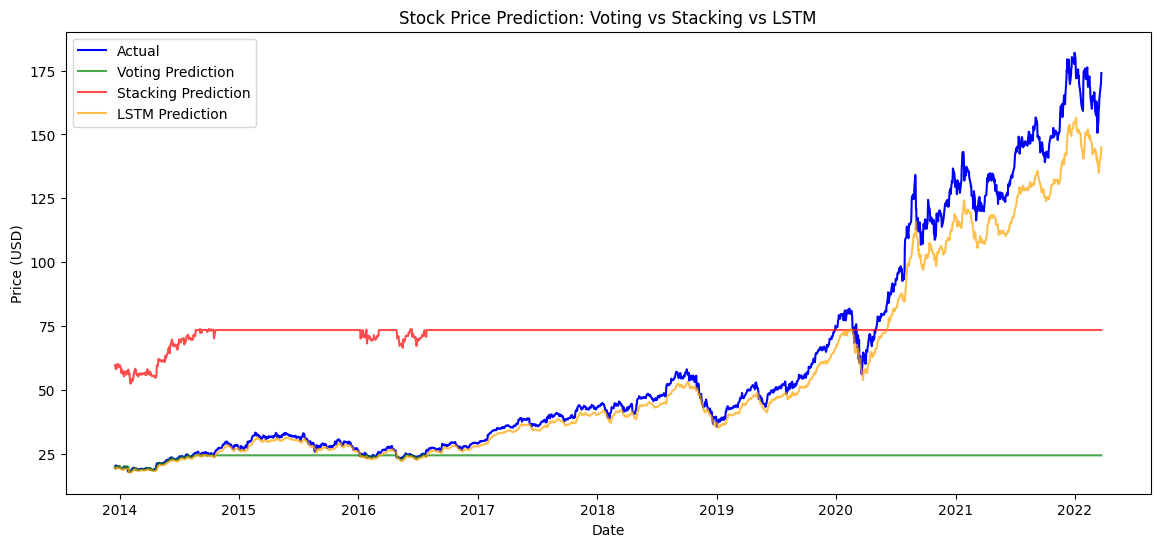

In [23]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'].iloc[-len(y_test):], y_test, label="Actual", color='blue')
plt.plot(df['Date'].iloc[-len(y_test):], y_pred_voting, label="Voting Prediction", color='green', alpha=0.7)
plt.plot(df['Date'].iloc[-len(y_test):], y_pred_stacking, label="Stacking Prediction", color='red', alpha=0.7)
plt.plot(df['Date'].iloc[-len(y_test):], y_pred_lstm, label="LSTM Prediction", color='orange', alpha=0.7)
plt.legend()
plt.title("Stock Price Prediction: Voting vs Stacking vs LSTM")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()